In [59]:
import Assignment2.df_filter_nvida as df_filter_nvida

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, BaseRepresentation
from bertopic.vectorizers import ClassTfidfTransformer
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mehdigreefhorst/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
news_articles_data = pd.read_csv("../data/us_equities_news_dataset.csv")
stock_data = pd.read_csv("../data/NVDA.csv")
nvida_news_articles_df = df_filter_nvida.filter_df_to_nvida(df=news_articles_data,
                                                            related_tickers="NVDA")
df_news = df_filter_nvida.add_nvidia_increase_decrease_bool_to_df(df_news=nvida_news_articles_df,
                                                                  df_stock_data=stock_data)
df_news = df_news.drop_duplicates(subset='content', keep='first').reset_index(drop=True)
df_news

nan
nan
nan
nan
nan
nan
nan
nan


,id,ticker,ticker_NVDA_improved,title,title_NVIDIA_topic,category,content,content_NVIDIA_topic,release_date,provider,url,article_id,NVIDIA_stock_increase
0,221539,NIO,True,A Central Bank War Just Started And Its Good F...,False,opinion,ECB Effects\nThe move in the euro was huge fa...,True,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,0
1,221547,NIO,True,6 Stocks To Watch Nivida Could Be Falling,False,opinion,6 Stocks To Watch March 6 Trading Session\nSt...,True,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,0
2,221572,NIO,True,Stocks Dow Drops Nearly 400 Points as Apple ...,False,news,Investing com A rout in Apple and Facebook ...,True,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,0
3,221593,UBER,True,The Zacks Analyst Blog Highlights Advanced Mi...,True,opinion,For Immediate ReleaseChicago IL January 13 ...,True,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,0
4,221597,UBER,True,The Best Of CES 2020 Revised,False,opinion,With 4 500 companies bringing their innovation...,True,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,442657,AMD,True,Here s Why Nvidia NVDA Stock Is Gaining Today,True,opinion,Shares of Nvidia NASDAQ NVDA are up nearly...,True,2016-09-27,Zacks Investment Research,https://www.investing.com/analysis/here's-why-...,200155860,1
3437,442682,AMD,True,4 Stocks To Watch Today ATW CWEI MXL SLCA,False,opinion,It was a pretty good start to the week on Mond...,True,2016-05-17,Harry Boxer,"https://www.investing.com/analysis/atw,-cwei,-...",200130262,1
3438,442705,AMD,True,Here s What The Buy Side Expects From AMD Thur...,False,opinion,Advanced Micro Devices Inc NYSE AMD is set ...,True,2014-04-17,Estimize,https://www.investing.com/analysis/here’s-what...,209915,1
3439,442984,T,True,Zacks com Featured Highlights AT T Nu Skin E...,True,opinion,For Immediate Release\n\nChicago IL July 22...,True,2016-07-21,Zacks Investment Research,https://www.investing.com/analysis/zacks.com-f...,200143537,0


In [61]:
def get_standard_bertopic(model_setting_index=0, customer_model_settings = None):
    """
    each of the steps in bertopic are assigned using the model settings, in the future this can be replaced with a grid search system to evaluate different model settings, but this is the most basic version with standard parameters. each of the model settings is in a list
    :param model_setting_index: defines which of the hyperparamter settings to pick
    :return: 
    """
    model_settings = [{
        "language": "",
        "nr_topics": "None",
        "document_embedding": 'SentenceTransformer("all-MiniLM-L6-v2")',
        "reduce_dimensionality": "UMAP()",
        "clustering": "HDBSCAN()",
        "topic_tokenization": 'CountVectorizer(stop_words="english")',
        "topic_representation": 'ClassTfidfTransformer()',
        "representation_model": 'KeyBERTInspired()'
    }]
    
    if customer_model_settings is not None:
        for key in model_settings[0].keys():
            if key not in customer_model_settings.keys():
                raise Exception(f"Missing key: {key}")
        model_settings.append(customer_model_settings)
            
            
    # Step 1 - Extract embeddings
    embedding_model = model_settings[model_setting_index]["document_embedding"]
    
    # Step 2 - Reduce dimensionality
    umap_model = model_settings[model_setting_index]["reduce_dimensionality"]

    # Step 3 - Cluster reduced embeddings
    hdbscan_model = model_settings[model_setting_index]["clustering"]

    # Step 4 - Tokenize topics
    vectorizer_model = model_settings[model_setting_index]["topic_tokenization"]

    # Step 5 - Create topic representation
    ctfidf_model = model_settings[model_setting_index]["topic_representation"]

    # Step 6 - (Optional) Fine-tune topic representations with
    # a `bertopic.representation` model
    representation_model = model_settings[model_setting_index]["representation_model"]
    
    language = model_settings[model_setting_index]["language"]

    # All steps together
    topic_model = BERTopic(
        language=language,
        nr_topics=model_settings[model_setting_index]["nr_topics"],
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=umap_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
        representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
    )
    return topic_model

def train_bertopic_model(documents, model_setting_index=0, customer_model_settings = None):
    """
    trains the bertopic model from the documents that are given as a parameter
    :param documents: an array of documents to get topics made of
    :param model_setting_index: specifies which batch of hyperparameters to pick that define bertopic. Standard = 0
    :return: 
    """
    topic_model = get_standard_bertopic(model_setting_index=model_setting_index, 
                                        customer_model_settings=customer_model_settings)
    topics, props = topic_model.fit_transform(documents)
    return topic_model, topics, props
    
def get_topics_that_relate_to_nvidia(topic_model):
    """
    this function finds the topics that relate most to the input words given which is NVIDIA
    :param topic_model: 
    :return: 
    """
    similar_topics, similarities = topic_model.find_topics("NVIDIA", top_n=3)
    for topic_nr, similarity in zip(similar_topics, similarities):
        print(f"topic_nr: {topic_nr} | similarity to NVIDIA: {similarity}")
        print(f"words with similarities for topic:")
        print(topic_model.get_topic(topic_nr))
        

def get_coherence(df, _topic_model, _topics_numbers):
    # add the new topic numbers to the "topic" column
    df['topic'] = _topics_numbers
    documents_per_topic = df.groupby(['topic'], as_index=False).agg({'content': ' '.join})
    cleaned_docs = _topic_model._preprocess_text(documents_per_topic.content.values)
    
    # Extract vectorizer and analyzer from BERTopic
    vectorizer = _topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    
    # Extract features for Topic Coherence evaluation
    #words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in _topic_model.get_topic(topic)] 
                   for topic in range(len(set(df["topic"]))-1)]
    
    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

def get_topic_diversity(topic_model):
    unique_words = set()
    total_words = 0
    
    for topic_nr, topic_similarity_word_list in topic_model.topic_representations_.items():
        # the first topic is not a topic, these are the outlier documents, so we should disregard these
        if topic_nr == -1:
            continue
        for topic_word, similarity in topic_similarity_word_list:
            
            total_words += 1
            unique_words.add(topic_word)
            
    topic_diversity = len(unique_words)/total_words
    return topic_diversity


def show_bertopic_evaluations(custom_bert_params, iteration=0):
    print("iteration = ", iteration)
    _topic_model_content, _topics_numbers, _probs_numbers = train_bertopic_model(df_news["content"],
                                                                                 model_setting_index=-1,
                                                                                 customer_model_settings=custom_bert_params)
    print("total number of topics = ", len(_topic_model_content.get_topic_info()))
    print("documents without a topic = ", _topic_model_content.get_topic_info(-1)["Count"].values[0])
    #print("topic diversity = ", get_topic_diversity(_topic_model_content))
    #print("topic coherence = ", get_coherence(df_news, _topic_model_content, _topics_numbers))
    _topic_model_content.visualize_topics().write_image(f'plots/intertopic_{iteration}.jpg')
    _topic_model_content.visualize_barchart(top_n_topics=60, n_words=10).write_image(f"plots/topicbar_{iteration}.jpg")
    return _topic_model_content, _topics_numbers, _probs_numbers



### Very good one!

In [57]:
custom_bert_parameters = {
    "language": "english",
    "nr_topics": "auto",
    "document_embedding": SentenceTransformer("all-MiniLM-L6-v2"),
    "reduce_dimensionality": UMAP(min_dist=0.05, spread=0.5),
    "clustering": HDBSCAN(min_cluster_size=15),
    "topic_tokenization": CountVectorizer(stop_words="english"),
    "topic_representation": ClassTfidfTransformer(reduce_frequent_words=True),
    "representation_model": KeyBERTInspired(top_n_words=20)
}
topic_, topicnum_, probs_ = show_bertopic_evaluations(custom_bert_parameters, iteration=205)



iteration =  205
topic model parameters =  {'calculate_probabilities': False, 'ctfidf_model': ClassTfidfTransformer(reduce_frequent_words=True), 'embedding_model': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), 'hdbscan_model': HDBSCAN(min_cluster_size=15), 'language': None, 'low_memory': False, 'min_topic_size': 10, 'n_gram_range': (1, 1), 'nr_topics': 'auto', 'representation_model': KeyBERTInspired(top_n_words=20), 'seed_topic_list': None, 'top_n_words': 10, 'umap_model': UMAP(min_dist=0.05, spread=0.5), 'vectorizer_model': CountVectorizer(stop_words='english'), 'verbose': False, 'zeroshot_min_sim

The sentence transformer chosen is all-MiniLM-L6-v2. This is one of the better models that Maarten Grootendorst has evaluated, but it has a much faster computation time than for example the best model "all-mpnet-base-v2", which would result in 2% better performance but a 5 times slower running time.

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from itertools import product
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

def create_parameter_grid():
    """Define the parameter grid for hyperparameter tuning."""
    param_grid = {
        "language": ["english"],  # keeping consistent with your implementation
        "nr_topics": ["auto"],
        "document_embedding": [
            SentenceTransformer("all-MiniLM-L6-v2"),
            #SentenceTransformer("all-mpnet-base-v2")
        ],
        "reduce_dimensionality": [
            UMAP(min_dist=d, n_neighbors=n)
            for d, n in product(
                [0.00, 0.05, 0.1],  # min_dist
                [10, 15, 20],  # n_neighbors
            )
        ],
        "clustering": [
            HDBSCAN(min_cluster_size=s, min_samples=m)
            for s, m in product(
                [5, 10, 15, 20],  # min_cluster_size
                [None, 5, 10]  # min_samples
            )
        ],
        "topic_tokenization": [
            CountVectorizer(stop_words="english", ngram_range=n)
            for n in [(1,1), (1,2)]  # ngram_range
                
            
        ],
        "topic_representation": [
            ClassTfidfTransformer(reduce_frequent_words=rf)
            for rf in [True]
        ],
        "representation_model": [KeyBERTInspired()]
    }
    return param_grid

def run_hyperparameter_tuning(df, max_combinations=3):
    """Run hyperparameter tuning using your existing functions."""
    param_grid = create_parameter_grid()
    results = []
    
    # Generate parameter combinations
    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))
    print("combinations to test= ", len(combinations))
    
    if max_combinations:
        combinations = combinations[:max_combinations]
    combo_iteration = 0
    for combo in tqdm(combinations, desc="Evaluating model configurations"):
        combo_iteration += 1
        try:
            # Create parameter dictionary for current combination
            current_params = dict(zip(param_keys, combo))
            
            # Use your existing function to train and evaluate the model
            topic_model, topics, probs = show_bertopic_evaluations(current_params, combo_iteration)
            
            # Get evaluation metrics
            topic_info = topic_model.get_topic_info()
            
            result = {
                # Configuration identifiers
                'iteration': combo_iteration,
                'embedding_model': current_params['document_embedding'].__class__.__name__,
                'umap_min_dist': current_params['reduce_dimensionality'].min_dist,
                'umap_n_neighbors': current_params['reduce_dimensionality'].n_neighbors,
                'umap_spread': current_params['reduce_dimensionality'].spread,
                'hdbscan_min_cluster_size': current_params['clustering'].min_cluster_size,
                'hdbscan_min_samples': current_params['clustering'].min_samples,
                'vectorizer_ngram_range': current_params['topic_tokenization'].ngram_range,
                'vectorizer_min_df': current_params['topic_tokenization'].min_df,
                'reduce_frequent_words': current_params['topic_representation'].reduce_frequent_words,
                'nr_topics_setting': str(current_params['nr_topics']),
                
                # Evaluation metrics (using your existing functions)
                'number_of_topics': len(topic_info),
                'docs_without_topic': topic_info.iloc[0]['Count'] if -1 in topics else 0,
                'topic_diversity': get_topic_diversity(topic_model),
                'topic_coherence': get_coherence(df, topic_model, topics),
                
                # Store the model and topics for later use if needed
                'model': topic_model,
                'topics': topics,
                'probs': probs
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"Error with configuration: {e}")
            continue
    
    return pd.DataFrame(results)

def plot_results(results_df):
    """Create visualizations for the hyperparameter tuning results."""
    # Remove the model and topics columns for plotting
    plot_df = results_df.drop(['model', 'topics', 'probs'], axis=1)
    
    # 3D scatter plot
    fig1 = go.Figure(data=[go.Scatter3d(
        x=plot_df['number_of_topics'],
        y=plot_df['topic_coherence'],
        z=plot_df['topic_diversity'],
        mode='markers',
        marker=dict(
            size=8,
            color=plot_df['docs_without_topic'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f"Config {i}" for i in range(len(plot_df))]
    )])
    
    fig1.update_layout(
        title='Topic Model Configurations in 3D Space',
        scene=dict(
            xaxis_title='Number of Topics',
            yaxis_title='Topic Coherence',
            zaxis_title='Topic Diversity'
        )
    )
    
    # Parallel coordinates plot
    fig2 = px.parallel_coordinates(plot_df,
        dimensions=['number_of_topics', 'topic_coherence', 'topic_diversity', 
                   'docs_without_topic', 'umap_min_dist', 'hdbscan_min_cluster_size'],
        title='Parallel Coordinates Plot of Model Configurations'
    )
    
    return fig1, fig2

def find_best_models(results_df, n_best=5):
    """Find the best performing models based on multiple metrics."""
    # Create normalized scores for each metric
    metrics = ['topic_coherence', 'topic_diversity', 'number_of_topics']
    
    # Remove non-numeric columns and normalize
    scoring_df = results_df.copy()
    for metric in metrics:
        max_val = scoring_df[metric].max()
        min_val = scoring_df[metric].min()
        scoring_df[f'{metric}_normalized'] = (scoring_df[metric] - min_val) / (max_val - min_val)
    
    # Calculate composite score (you can adjust weights as needed)
    scoring_df['composite_score'] = (
        scoring_df['topic_coherence_normalized'] * 0.4 +
        scoring_df['topic_diversity_normalized'] * 0.3 +
        scoring_df['number_of_topics_normalized'] * 0.3
    )
    
    # Penalize for documents without topics
    scoring_df['composite_score'] = scoring_df['composite_score'] * (
        1 - scoring_df['docs_without_topic'] / scoring_df['docs_without_topic'].max()
    )
    
    # Get best models
    best_models = scoring_df.nlargest(n_best, 'composite_score')
    return best_models

# Example usage:
results_df = run_hyperparameter_tuning(df_news, max_combinations=216)
fig1, fig2 = plot_results(results_df)
fig1.show()
fig2.show()
best_models = find_best_models(results_df)
print("Best performing models:")
print(best_models[['composite_score', 'number_of_topics', 'topic_coherence', 'topic_diversity', 'docs_without_topic']])

combinations to test=  216


Evaluating model configurations:   0%|          | 0/216 [00:00<?, ?it/s]

iteration =  1


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


total number of topics =  49
documents without a topic =  768


Evaluating model configurations:   0%|          | 1/216 [01:04<3:51:37, 64.64s/it]

iteration =  2
total number of topics =  47
documents without a topic =  747


Evaluating model configurations:   1%|          | 2/216 [02:18<4:09:57, 70.08s/it]

iteration =  3
total number of topics =  44
documents without a topic =  857


Evaluating model configurations:   1%|▏         | 3/216 [03:17<3:50:06, 64.82s/it]

iteration =  4
total number of topics =  91
documents without a topic =  763


Evaluating model configurations:   2%|▏         | 4/216 [04:37<4:10:52, 71.00s/it]

iteration =  5
total number of topics =  27
documents without a topic =  908


Evaluating model configurations:   2%|▏         | 5/216 [05:25<3:40:49, 62.80s/it]

iteration =  6
total number of topics =  38
documents without a topic =  876


Evaluating model configurations:   3%|▎         | 6/216 [06:32<3:44:28, 64.14s/it]

iteration =  7
total number of topics =  16
documents without a topic =  928


Evaluating model configurations:   3%|▎         | 7/216 [07:17<3:21:11, 57.76s/it]

iteration =  8
total number of topics =  20
documents without a topic =  886


Evaluating model configurations:   4%|▎         | 8/216 [08:18<3:23:39, 58.75s/it]

iteration =  9
total number of topics =  60
documents without a topic =  768


Evaluating model configurations:   4%|▍         | 9/216 [09:15<3:21:17, 58.35s/it]

iteration =  10
total number of topics =  23
documents without a topic =  695


Evaluating model configurations:   5%|▍         | 10/216 [10:17<3:24:11, 59.48s/it]

iteration =  11
total number of topics =  43
documents without a topic =  1014


Evaluating model configurations:   5%|▌         | 11/216 [11:10<3:16:35, 57.54s/it]

iteration =  12
total number of topics =  37
documents without a topic =  796


Evaluating model configurations:   6%|▌         | 12/216 [12:16<3:24:04, 60.02s/it]

iteration =  13
total number of topics =  36
documents without a topic =  847


Evaluating model configurations:   6%|▌         | 13/216 [13:06<3:12:49, 56.99s/it]

iteration =  14
total number of topics =  29
documents without a topic =  831


Evaluating model configurations:   6%|▋         | 14/216 [14:08<3:16:56, 58.50s/it]

iteration =  15
total number of topics =  25
documents without a topic =  616


Evaluating model configurations:   7%|▋         | 15/216 [14:54<3:03:00, 54.63s/it]

iteration =  16
total number of topics =  33
documents without a topic =  664


Evaluating model configurations:   7%|▋         | 16/216 [15:56<3:10:00, 57.00s/it]

iteration =  17
total number of topics =  28
documents without a topic =  886


Evaluating model configurations:   8%|▊         | 17/216 [16:42<2:57:37, 53.56s/it]

iteration =  18
total number of topics =  24
documents without a topic =  713


Evaluating model configurations:   8%|▊         | 18/216 [17:40<3:02:03, 55.17s/it]

iteration =  19
total number of topics =  28
documents without a topic =  1022


Evaluating model configurations:   9%|▉         | 19/216 [18:25<2:50:43, 52.00s/it]

iteration =  20
total number of topics =  32
documents without a topic =  1050


Evaluating model configurations:   9%|▉         | 20/216 [19:27<2:59:16, 54.88s/it]

iteration =  21
total number of topics =  20
documents without a topic =  713


Evaluating model configurations:  10%|▉         | 21/216 [20:10<2:46:37, 51.27s/it]

iteration =  22
total number of topics =  25
documents without a topic =  786


Evaluating model configurations:  10%|█         | 22/216 [21:08<2:52:40, 53.40s/it]

iteration =  23
total number of topics =  16
documents without a topic =  799


Evaluating model configurations:  11%|█         | 23/216 [21:49<2:39:25, 49.56s/it]

iteration =  24
total number of topics =  39
documents without a topic =  747


Evaluating model configurations:  11%|█         | 24/216 [22:50<2:50:22, 53.24s/it]

iteration =  25
total number of topics =  116
documents without a topic =  803


Evaluating model configurations:  12%|█▏        | 25/216 [23:58<3:03:16, 57.57s/it]

iteration =  26
total number of topics =  59
documents without a topic =  861


Evaluating model configurations:  12%|█▏        | 26/216 [25:08<3:14:21, 61.38s/it]

iteration =  27
total number of topics =  36
documents without a topic =  793


Evaluating model configurations:  12%|█▎        | 27/216 [26:01<3:05:18, 58.83s/it]

iteration =  28
total number of topics =  36
documents without a topic =  765


Evaluating model configurations:  13%|█▎        | 28/216 [27:07<3:11:19, 61.06s/it]

iteration =  29
total number of topics =  25
documents without a topic =  1011


Evaluating model configurations:  13%|█▎        | 29/216 [27:53<2:55:48, 56.41s/it]

iteration =  30
total number of topics =  43
documents without a topic =  827


Evaluating model configurations:  14%|█▍        | 30/216 [28:57<3:01:37, 58.59s/it]

iteration =  31
total number of topics =  11
documents without a topic =  911


Evaluating model configurations:  14%|█▍        | 31/216 [29:37<2:44:01, 53.20s/it]

iteration =  32
total number of topics =  33
documents without a topic =  895


Evaluating model configurations:  15%|█▍        | 32/216 [30:39<2:50:41, 55.66s/it]

iteration =  33
total number of topics =  58
documents without a topic =  832


Evaluating model configurations:  15%|█▌        | 33/216 [31:36<2:50:49, 56.01s/it]

iteration =  34
total number of topics =  25
documents without a topic =  859


Evaluating model configurations:  16%|█▌        | 34/216 [32:38<2:55:23, 57.82s/it]

iteration =  35
total number of topics =  53
documents without a topic =  931


Evaluating model configurations:  16%|█▌        | 35/216 [33:33<2:52:40, 57.24s/it]

iteration =  36
total number of topics =  44
documents without a topic =  890


Evaluating model configurations:  17%|█▋        | 36/216 [34:38<2:58:33, 59.52s/it]

iteration =  37
total number of topics =  28
documents without a topic =  877


Evaluating model configurations:  17%|█▋        | 37/216 [35:22<2:43:46, 54.90s/it]

iteration =  38
total number of topics =  19
documents without a topic =  1104


Evaluating model configurations:  18%|█▊        | 38/216 [36:19<2:44:45, 55.54s/it]

iteration =  39
total number of topics =  10
documents without a topic =  628


Evaluating model configurations:  18%|█▊        | 39/216 [37:00<2:30:22, 50.97s/it]

iteration =  40
total number of topics =  24
documents without a topic =  690


Evaluating model configurations:  19%|█▊        | 40/216 [37:58<2:35:57, 53.16s/it]

iteration =  41
total number of topics =  13
documents without a topic =  826


Evaluating model configurations:  19%|█▉        | 41/216 [38:39<2:24:30, 49.54s/it]

iteration =  42
total number of topics =  12
documents without a topic =  809


Evaluating model configurations:  19%|█▉        | 42/216 [39:34<2:28:11, 51.10s/it]

iteration =  43
total number of topics =  36
documents without a topic =  940


Evaluating model configurations:  20%|█▉        | 43/216 [40:22<2:24:39, 50.17s/it]

iteration =  44
total number of topics =  33
documents without a topic =  928


Evaluating model configurations:  20%|██        | 44/216 [41:22<2:32:45, 53.29s/it]

iteration =  45
total number of topics =  18
documents without a topic =  816


Evaluating model configurations:  21%|██        | 45/216 [42:05<2:22:39, 50.06s/it]

iteration =  46
total number of topics =  29
documents without a topic =  625


Evaluating model configurations:  21%|██▏       | 46/216 [43:05<2:30:41, 53.18s/it]

iteration =  47
total number of topics =  20
documents without a topic =  879


Evaluating model configurations:  22%|██▏       | 47/216 [43:47<2:20:05, 49.74s/it]

iteration =  48
total number of topics =  20
documents without a topic =  812


Evaluating model configurations:  22%|██▏       | 48/216 [44:45<2:25:50, 52.08s/it]

iteration =  49
total number of topics =  37
documents without a topic =  912


Evaluating model configurations:  23%|██▎       | 49/216 [45:40<2:27:18, 52.93s/it]

iteration =  50
total number of topics =  97
documents without a topic =  898


Evaluating model configurations:  23%|██▎       | 50/216 [46:56<2:46:18, 60.11s/it]

iteration =  51
total number of topics =  35
documents without a topic =  932


Evaluating model configurations:  24%|██▎       | 51/216 [47:49<2:39:12, 57.89s/it]

iteration =  52
total number of topics =  90
documents without a topic =  852


Evaluating model configurations:  24%|██▍       | 52/216 [49:05<2:53:12, 63.37s/it]

iteration =  53
total number of topics =  50
documents without a topic =  907


Evaluating model configurations:  25%|██▍       | 53/216 [49:58<2:43:24, 60.15s/it]

iteration =  54
total number of topics =  33
documents without a topic =  869


Evaluating model configurations:  25%|██▌       | 54/216 [50:58<2:42:36, 60.23s/it]

iteration =  55
total number of topics =  31
documents without a topic =  888


Evaluating model configurations:  25%|██▌       | 55/216 [51:44<2:29:57, 55.88s/it]

iteration =  56
total number of topics =  13
documents without a topic =  849


Evaluating model configurations:  26%|██▌       | 56/216 [52:40<2:29:22, 56.01s/it]

iteration =  57
total number of topics =  14
documents without a topic =  800


Evaluating model configurations:  26%|██▋       | 57/216 [53:23<2:17:24, 51.85s/it]

iteration =  58
total number of topics =  21
documents without a topic =  766


Evaluating model configurations:  27%|██▋       | 58/216 [54:22<2:22:55, 54.27s/it]

iteration =  59
total number of topics =  45
documents without a topic =  1029


Evaluating model configurations:  27%|██▋       | 59/216 [55:16<2:21:04, 53.91s/it]

iteration =  60
total number of topics =  46
documents without a topic =  965


Evaluating model configurations:  28%|██▊       | 60/216 [56:21<2:29:28, 57.49s/it]

iteration =  61
total number of topics =  32
documents without a topic =  834


Evaluating model configurations:  28%|██▊       | 61/216 [57:07<2:19:28, 53.99s/it]

iteration =  62
total number of topics =  8
documents without a topic =  1065


Evaluating model configurations:  29%|██▊       | 62/216 [58:01<2:18:41, 54.04s/it]

iteration =  63
total number of topics =  29
documents without a topic =  700


Evaluating model configurations:  29%|██▉       | 63/216 [58:47<2:11:33, 51.59s/it]

iteration =  64
total number of topics =  21
documents without a topic =  762


Evaluating model configurations:  30%|██▉       | 64/216 [59:46<2:16:15, 53.79s/it]

iteration =  65
total number of topics =  22
documents without a topic =  734


Evaluating model configurations:  30%|███       | 65/216 [1:00:30<2:07:41, 50.74s/it]

iteration =  66
total number of topics =  36
documents without a topic =  702


Evaluating model configurations:  31%|███       | 66/216 [1:01:32<2:15:10, 54.07s/it]

iteration =  67
total number of topics =  24
documents without a topic =  780


Evaluating model configurations:  31%|███       | 67/216 [1:02:14<2:05:40, 50.61s/it]

iteration =  68
total number of topics =  28
documents without a topic =  1028


Evaluating model configurations:  31%|███▏      | 68/216 [1:03:13<2:10:35, 52.95s/it]

iteration =  69
total number of topics =  21
documents without a topic =  736


Evaluating model configurations:  32%|███▏      | 69/216 [1:03:56<2:02:56, 50.18s/it]

iteration =  70
total number of topics =  18
documents without a topic =  620


Evaluating model configurations:  32%|███▏      | 70/216 [1:04:54<2:07:23, 52.35s/it]

iteration =  71
total number of topics =  23
documents without a topic =  903


Evaluating model configurations:  33%|███▎      | 71/216 [1:05:37<1:59:43, 49.54s/it]

iteration =  72
total number of topics =  20
documents without a topic =  854


Evaluating model configurations:  33%|███▎      | 72/216 [1:06:34<2:04:14, 51.77s/it]

iteration =  73
total number of topics =  56
documents without a topic =  782


Evaluating model configurations:  34%|███▍      | 73/216 [1:07:33<2:08:27, 53.90s/it]

iteration =  74
total number of topics =  87
documents without a topic =  704


Evaluating model configurations:  34%|███▍      | 74/216 [1:08:47<2:22:23, 60.17s/it]

iteration =  75
total number of topics =  88
documents without a topic =  750


Evaluating model configurations:  35%|███▍      | 75/216 [1:09:54<2:25:46, 62.03s/it]

iteration =  76
total number of topics =  83
documents without a topic =  773


Evaluating model configurations:  35%|███▌      | 76/216 [1:11:08<2:33:25, 65.75s/it]

iteration =  77
total number of topics =  68
documents without a topic =  1051


Evaluating model configurations:  36%|███▌      | 77/216 [1:12:06<2:27:05, 63.49s/it]

iteration =  78
total number of topics =  10
documents without a topic =  794


Evaluating model configurations:  36%|███▌      | 78/216 [1:13:02<2:20:31, 61.10s/it]

iteration =  79
total number of topics =  35
documents without a topic =  998


Evaluating model configurations:  37%|███▋      | 79/216 [1:13:49<2:10:15, 57.04s/it]

iteration =  80
total number of topics =  14
documents without a topic =  907


Evaluating model configurations:  37%|███▋      | 80/216 [1:14:47<2:09:20, 57.06s/it]

iteration =  81
total number of topics =  61
documents without a topic =  733


Evaluating model configurations:  38%|███▊      | 81/216 [1:15:44<2:08:23, 57.06s/it]

iteration =  82
total number of topics =  25
documents without a topic =  771


Evaluating model configurations:  38%|███▊      | 82/216 [1:16:45<2:10:11, 58.29s/it]

iteration =  83
total number of topics =  48
documents without a topic =  879


Evaluating model configurations:  38%|███▊      | 83/216 [1:17:38<2:05:54, 56.80s/it]

iteration =  84
total number of topics =  34
documents without a topic =  923


Evaluating model configurations:  39%|███▉      | 84/216 [1:18:41<2:09:18, 58.78s/it]

iteration =  85
total number of topics =  20
documents without a topic =  1061


Evaluating model configurations:  39%|███▉      | 85/216 [1:19:24<1:57:29, 53.81s/it]

iteration =  86
total number of topics =  12
documents without a topic =  905


Evaluating model configurations:  40%|███▉      | 86/216 [1:20:19<1:57:35, 54.28s/it]

iteration =  87
total number of topics =  25
documents without a topic =  842


Evaluating model configurations:  40%|████      | 87/216 [1:21:03<1:50:17, 51.30s/it]

iteration =  88
total number of topics =  48
documents without a topic =  812


Evaluating model configurations:  41%|████      | 88/216 [1:22:08<1:58:14, 55.42s/it]

iteration =  89
total number of topics =  24
documents without a topic =  1021


Evaluating model configurations:  41%|████      | 89/216 [1:22:53<1:50:19, 52.12s/it]

iteration =  90
total number of topics =  25
documents without a topic =  937


Evaluating model configurations:  42%|████▏     | 90/216 [1:23:53<1:54:35, 54.57s/it]

iteration =  91
total number of topics =  25
documents without a topic =  1209


Evaluating model configurations:  42%|████▏     | 91/216 [1:24:37<1:46:40, 51.20s/it]

iteration =  92
total number of topics =  27
documents without a topic =  1030


Evaluating model configurations:  43%|████▎     | 92/216 [1:25:37<1:51:28, 53.94s/it]

iteration =  93
total number of topics =  25
documents without a topic =  896


Evaluating model configurations:  43%|████▎     | 93/216 [1:26:21<1:44:42, 51.08s/it]

iteration =  94
total number of topics =  16
documents without a topic =  766


Evaluating model configurations:  44%|████▎     | 94/216 [1:27:19<1:48:05, 53.16s/it]

iteration =  95
total number of topics =  28
documents without a topic =  922


Evaluating model configurations:  44%|████▍     | 95/216 [1:28:04<1:42:20, 50.75s/it]

iteration =  96
total number of topics =  20
documents without a topic =  1044


Evaluating model configurations:  44%|████▍     | 96/216 [1:29:03<1:46:13, 53.11s/it]

iteration =  97
total number of topics =  63
documents without a topic =  860


Evaluating model configurations:  45%|████▍     | 97/216 [1:30:03<1:49:42, 55.31s/it]

iteration =  98
total number of topics =  95
documents without a topic =  876


Evaluating model configurations:  45%|████▌     | 98/216 [1:31:20<2:01:05, 61.57s/it]

iteration =  99
total number of topics =  93
documents without a topic =  897


Evaluating model configurations:  46%|████▌     | 99/216 [1:32:27<2:03:26, 63.31s/it]

iteration =  100
total number of topics =  42
documents without a topic =  929


Evaluating model configurations:  46%|████▋     | 100/216 [1:33:35<2:04:50, 64.57s/it]

iteration =  101
total number of topics =  48
documents without a topic =  1081


Evaluating model configurations:  47%|████▋     | 101/216 [1:34:28<1:57:20, 61.23s/it]

iteration =  102
total number of topics =  56
documents without a topic =  993


Evaluating model configurations:  47%|████▋     | 102/216 [1:35:34<1:59:19, 62.80s/it]

iteration =  103
total number of topics =  16
documents without a topic =  973


Evaluating model configurations:  48%|████▊     | 103/216 [1:36:16<1:46:25, 56.51s/it]

iteration =  104
total number of topics =  31
documents without a topic =  937


Evaluating model configurations:  48%|████▊     | 104/216 [1:37:17<1:48:00, 57.86s/it]

iteration =  105
total number of topics =  64
documents without a topic =  790


Evaluating model configurations:  49%|████▊     | 105/216 [1:38:17<1:47:49, 58.28s/it]

iteration =  106
total number of topics =  60
documents without a topic =  792


Evaluating model configurations:  49%|████▉     | 106/216 [1:39:27<1:53:17, 61.80s/it]

iteration =  107
total number of topics =  14
documents without a topic =  755


Evaluating model configurations:  50%|████▉     | 107/216 [1:40:08<1:41:05, 55.64s/it]

iteration =  108
total number of topics =  18
documents without a topic =  838


Evaluating model configurations:  50%|█████     | 108/216 [1:41:05<1:41:12, 56.23s/it]

iteration =  109
total number of topics =  18
documents without a topic =  957


Evaluating model configurations:  50%|█████     | 109/216 [1:41:47<1:32:19, 51.78s/it]

iteration =  110
total number of topics =  37
documents without a topic =  930


Evaluating model configurations:  51%|█████     | 110/216 [1:42:51<1:37:56, 55.44s/it]

iteration =  111
total number of topics =  33
documents without a topic =  818


Evaluating model configurations:  51%|█████▏    | 111/216 [1:43:37<1:32:22, 52.79s/it]

iteration =  112
total number of topics =  38
documents without a topic =  712


Evaluating model configurations:  52%|█████▏    | 112/216 [1:44:40<1:36:43, 55.80s/it]

iteration =  113
total number of topics =  32
documents without a topic =  885


Evaluating model configurations:  52%|█████▏    | 113/216 [1:45:26<1:30:32, 52.74s/it]

iteration =  114
total number of topics =  33
documents without a topic =  799


Evaluating model configurations:  53%|█████▎    | 114/216 [1:46:27<1:33:55, 55.25s/it]

iteration =  115
total number of topics =  25
documents without a topic =  985


Evaluating model configurations:  53%|█████▎    | 115/216 [1:47:10<1:26:46, 51.55s/it]

iteration =  116
total number of topics =  27
documents without a topic =  1137


Evaluating model configurations:  54%|█████▎    | 116/216 [1:48:11<1:30:50, 54.50s/it]

iteration =  117
total number of topics =  10
documents without a topic =  719


Evaluating model configurations:  54%|█████▍    | 117/216 [1:48:52<1:23:01, 50.31s/it]

iteration =  118
total number of topics =  39
documents without a topic =  657


Evaluating model configurations:  55%|█████▍    | 118/216 [1:49:56<1:28:57, 54.47s/it]

iteration =  119
total number of topics =  36
documents without a topic =  848


Evaluating model configurations:  55%|█████▌    | 119/216 [1:50:43<1:24:38, 52.36s/it]

iteration =  120
total number of topics =  33
documents without a topic =  984


Evaluating model configurations:  56%|█████▌    | 120/216 [1:51:45<1:28:08, 55.09s/it]

iteration =  121
total number of topics =  80
documents without a topic =  918


Evaluating model configurations:  56%|█████▌    | 121/216 [1:52:53<1:33:23, 58.98s/it]

iteration =  122
total number of topics =  101
documents without a topic =  921


Evaluating model configurations:  56%|█████▋    | 122/216 [1:54:11<1:41:15, 64.63s/it]

iteration =  123
total number of topics =  61
documents without a topic =  785


Evaluating model configurations:  57%|█████▋    | 123/216 [1:55:16<1:40:23, 64.77s/it]

iteration =  124
total number of topics =  99
documents without a topic =  990


Evaluating model configurations:  57%|█████▋    | 124/216 [1:56:38<1:47:24, 70.05s/it]

iteration =  125
total number of topics =  38
documents without a topic =  1128


Evaluating model configurations:  58%|█████▊    | 125/216 [1:57:30<1:37:57, 64.59s/it]

iteration =  126
total number of topics =  35
documents without a topic =  931


Evaluating model configurations:  58%|█████▊    | 126/216 [1:58:33<1:36:03, 64.03s/it]

iteration =  127
total number of topics =  11
documents without a topic =  859


Evaluating model configurations:  59%|█████▉    | 127/216 [1:59:14<1:24:47, 57.16s/it]

iteration =  128
total number of topics =  27
documents without a topic =  956


Evaluating model configurations:  59%|█████▉    | 128/216 [2:00:20<1:27:34, 59.71s/it]

iteration =  129
total number of topics =  20
documents without a topic =  868


Evaluating model configurations:  60%|█████▉    | 129/216 [2:01:08<1:21:29, 56.20s/it]

iteration =  130
total number of topics =  41
documents without a topic =  743


Evaluating model configurations:  60%|██████    | 130/216 [2:02:22<1:28:35, 61.81s/it]

iteration =  131
total number of topics =  22
documents without a topic =  958


Evaluating model configurations:  61%|██████    | 131/216 [2:03:09<1:21:09, 57.29s/it]

iteration =  132
total number of topics =  40
documents without a topic =  904


Evaluating model configurations:  61%|██████    | 132/216 [2:04:20<1:25:54, 61.36s/it]

iteration =  133
total number of topics =  37
documents without a topic =  955


Evaluating model configurations:  62%|██████▏   | 133/216 [2:05:13<1:21:12, 58.71s/it]

iteration =  134
total number of topics =  24
documents without a topic =  1031


Evaluating model configurations:  62%|██████▏   | 134/216 [2:06:15<1:21:43, 59.80s/it]

iteration =  135
total number of topics =  41
documents without a topic =  669


Evaluating model configurations:  62%|██████▎   | 135/216 [2:07:08<1:18:04, 57.84s/it]

iteration =  136
total number of topics =  21
documents without a topic =  818


Evaluating model configurations:  63%|██████▎   | 136/216 [2:08:13<1:19:54, 59.93s/it]

iteration =  137
total number of topics =  9
documents without a topic =  969


Evaluating model configurations:  63%|██████▎   | 137/216 [2:08:57<1:12:30, 55.07s/it]

iteration =  138
total number of topics =  42
documents without a topic =  856


Evaluating model configurations:  64%|██████▍   | 138/216 [2:10:05<1:16:53, 59.15s/it]

iteration =  139
total number of topics =  25
documents without a topic =  872


Evaluating model configurations:  64%|██████▍   | 139/216 [2:10:52<1:11:16, 55.54s/it]

iteration =  140
total number of topics =  22
documents without a topic =  1079


Evaluating model configurations:  65%|██████▍   | 140/216 [2:11:53<1:12:14, 57.03s/it]

iteration =  141
total number of topics =  29
documents without a topic =  645


Evaluating model configurations:  65%|██████▌   | 141/216 [2:12:43<1:08:40, 54.94s/it]

iteration =  142
total number of topics =  27
documents without a topic =  892


Evaluating model configurations:  66%|██████▌   | 142/216 [2:13:53<1:13:18, 59.44s/it]

iteration =  143
total number of topics =  31
documents without a topic =  896


Evaluating model configurations:  66%|██████▌   | 143/216 [2:14:44<1:09:11, 56.86s/it]

iteration =  144
total number of topics =  31
documents without a topic =  839


Evaluating model configurations:  67%|██████▋   | 144/216 [2:15:54<1:12:56, 60.78s/it]

iteration =  145
total number of topics =  106
documents without a topic =  882


Evaluating model configurations:  67%|██████▋   | 145/216 [2:17:17<1:20:00, 67.61s/it]

iteration =  146
total number of topics =  90
documents without a topic =  861


Evaluating model configurations:  68%|██████▊   | 146/216 [2:18:50<1:27:41, 75.16s/it]

iteration =  147
total number of topics =  82
documents without a topic =  897


Evaluating model configurations:  68%|██████▊   | 147/216 [2:20:01<1:24:54, 73.83s/it]

iteration =  148
total number of topics =  29
documents without a topic =  959


Evaluating model configurations:  69%|██████▊   | 148/216 [2:21:13<1:23:02, 73.28s/it]

iteration =  149
total number of topics =  52
documents without a topic =  905


Evaluating model configurations:  69%|██████▉   | 149/216 [2:22:11<1:16:46, 68.75s/it]

iteration =  150
total number of topics =  56
documents without a topic =  1028


Evaluating model configurations:  69%|██████▉   | 150/216 [2:23:27<1:18:00, 70.92s/it]

iteration =  151
total number of topics =  44
documents without a topic =  1104


Evaluating model configurations:  70%|██████▉   | 151/216 [2:24:25<1:12:34, 66.99s/it]

iteration =  152
total number of topics =  35
documents without a topic =  901


Evaluating model configurations:  70%|███████   | 152/216 [2:25:34<1:12:09, 67.65s/it]

iteration =  153
total number of topics =  53
documents without a topic =  801


Evaluating model configurations:  71%|███████   | 153/216 [2:26:33<1:08:18, 65.05s/it]

iteration =  154
total number of topics =  59
documents without a topic =  811


Evaluating model configurations:  71%|███████▏  | 154/216 [2:27:48<1:10:14, 67.97s/it]

iteration =  155
total number of topics =  42
documents without a topic =  1031


Evaluating model configurations:  72%|███████▏  | 155/216 [2:28:50<1:07:26, 66.34s/it]

iteration =  156
total number of topics =  48
documents without a topic =  1114


Evaluating model configurations:  72%|███████▏  | 156/216 [2:30:05<1:08:52, 68.87s/it]

iteration =  157
total number of topics =  16
documents without a topic =  1194


Evaluating model configurations:  73%|███████▎  | 157/216 [2:30:52<1:01:07, 62.16s/it]

iteration =  158
total number of topics =  37
documents without a topic =  1249


Evaluating model configurations:  73%|███████▎  | 158/216 [2:32:02<1:02:28, 64.62s/it]

iteration =  159
total number of topics =  38
documents without a topic =  758


Evaluating model configurations:  74%|███████▎  | 159/216 [2:32:58<59:00, 62.11s/it]  

iteration =  160
total number of topics =  54
documents without a topic =  947


Evaluating model configurations:  74%|███████▍  | 160/216 [2:34:09<1:00:18, 64.62s/it]

iteration =  161
total number of topics =  29
documents without a topic =  954


Evaluating model configurations:  75%|███████▍  | 161/216 [2:34:58<55:02, 60.04s/it]  

iteration =  162
total number of topics =  38
documents without a topic =  927


Evaluating model configurations:  75%|███████▌  | 162/216 [2:36:06<56:14, 62.49s/it]

iteration =  163
total number of topics =  23
documents without a topic =  1213


Evaluating model configurations:  75%|███████▌  | 163/216 [2:36:50<50:12, 56.84s/it]

iteration =  164
total number of topics =  24
documents without a topic =  1049


Evaluating model configurations:  76%|███████▌  | 164/216 [2:37:50<50:07, 57.83s/it]

iteration =  165
total number of topics =  31
documents without a topic =  748


Evaluating model configurations:  76%|███████▋  | 165/216 [2:38:39<46:55, 55.21s/it]

iteration =  166
total number of topics =  19
documents without a topic =  783


Evaluating model configurations:  77%|███████▋  | 166/216 [2:39:38<46:53, 56.27s/it]

iteration =  167
total number of topics =  18
documents without a topic =  1108


Evaluating model configurations:  77%|███████▋  | 167/216 [2:40:22<42:54, 52.55s/it]

iteration =  168
total number of topics =  9
documents without a topic =  956


### Interpretability
The interpretability scores merges the information from topic diversity and topic coherence into a single variable by multiplying the diversity and coherence scores

In [10]:
results_df["interpretability"] = results_df["topic_diversity"] * results_df["topic_coherence"]

In [21]:
results_df.to_csv("results_hyperparameters.csv")
results_df

,iteration,embedding_model,umap_min_dist,umap_n_neighbors,umap_spread,hdbscan_min_cluster_size,hdbscan_min_samples,vectorizer_ngram_range,vectorizer_min_df,reduce_frequent_words,nr_topics_setting,number_of_topics,docs_without_topic,topic_diversity,topic_coherence,model,topics,probs,interpretability
0,1,SentenceTransformer,0.0,5,1.0,5,NaN,"(1, 1)",1,True,auto,28,1016,0.533333,0.555541,"BERTopic(calculate_probabilities=False, ctfidf...","[1, -1, -1, 0, -1, -1, -1, 4, 4, 2, 1, -1, 1, ...","[0.8373053634974206, 0.0, 0.0, 0.4397765811621...",0.296288
1,2,SentenceTransformer,0.0,5,1.0,5,NaN,"(1, 2)",1,True,auto,30,940,0.575862,0.553024,"BERTopic(calculate_probabilities=False, ctfidf...","[0, -1, -1, -1, -1, 10, -1, 2, 2, 1, 0, 0, -1,...","[0.7770868550416034, 0.0, 0.0, 0.0, 0.0, 0.799...",0.318466
2,3,SentenceTransformer,0.0,5,1.0,5,5.0,"(1, 1)",1,True,auto,46,970,0.442222,0.535579,"BERTopic(calculate_probabilities=False, ctfidf...","[16, -1, 34, -1, -1, -1, -1, 2, 2, 0, 5, -1, 3...","[0.7659643887123255, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.236845
3,4,SentenceTransformer,0.0,5,1.0,5,5.0,"(1, 2)",1,True,auto,26,1021,0.592000,0.573346,"BERTopic(calculate_probabilities=False, ctfidf...","[1, -1, 1, -1, -1, -1, -1, 3, 3, 2, 1, 0, -1, ...","[0.6468233122862297, 0.0, 0.7437987428682535, ...",0.339421
4,5,SentenceTransformer,0.0,5,1.0,5,10.0,"(1, 1)",1,True,auto,20,947,0.578947,0.559457,"BERTopic(calculate_probabilities=False, ctfidf...","[0, -1, 0, 0, 0, 0, -1, 2, 2, 3, 0, 0, -1, 2, ...","[0.5764024024672486, 0.0, 0.8225411625863547, ...",0.323896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,140,SentenceTransformer,0.1,15,1.0,20,NaN,"(1, 2)",1,True,auto,34,954,0.530303,0.554778,"BERTopic(calculate_probabilities=False, ctfidf...","[-1, -1, 0, -1, 16, 16, -1, 2, 2, 1, 0, 0, -1,...","[0.0, 0.0, 0.9869658601222523, 0.0, 0.79346411...",0.294201
140,141,SentenceTransformer,0.1,15,1.0,20,5.0,"(1, 1)",1,True,auto,23,1069,0.609091,0.565248,"BERTopic(calculate_probabilities=False, ctfidf...","[0, -1, 0, 0, 0, 0, -1, 2, 2, 1, 0, -1, -1, 2,...","[0.8292426899785187, 0.0, 1.0, 0.8991593883132...",0.344288
141,142,SentenceTransformer,0.1,15,1.0,20,5.0,"(1, 2)",1,True,auto,30,1120,0.537931,0.561197,"BERTopic(calculate_probabilities=False, ctfidf...","[7, -1, -1, -1, -1, -1, -1, 2, 2, 1, 0, -1, 0,...","[0.7047130479918264, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.301885
142,143,SentenceTransformer,0.1,15,1.0,20,10.0,"(1, 1)",1,True,auto,35,1007,0.467647,0.540970,"BERTopic(calculate_probabilities=False, ctfidf...","[8, -1, -1, -1, -1, -1, -1, 3, 3, 1, 6, 0, -1,...","[0.7193489801061933, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.252983


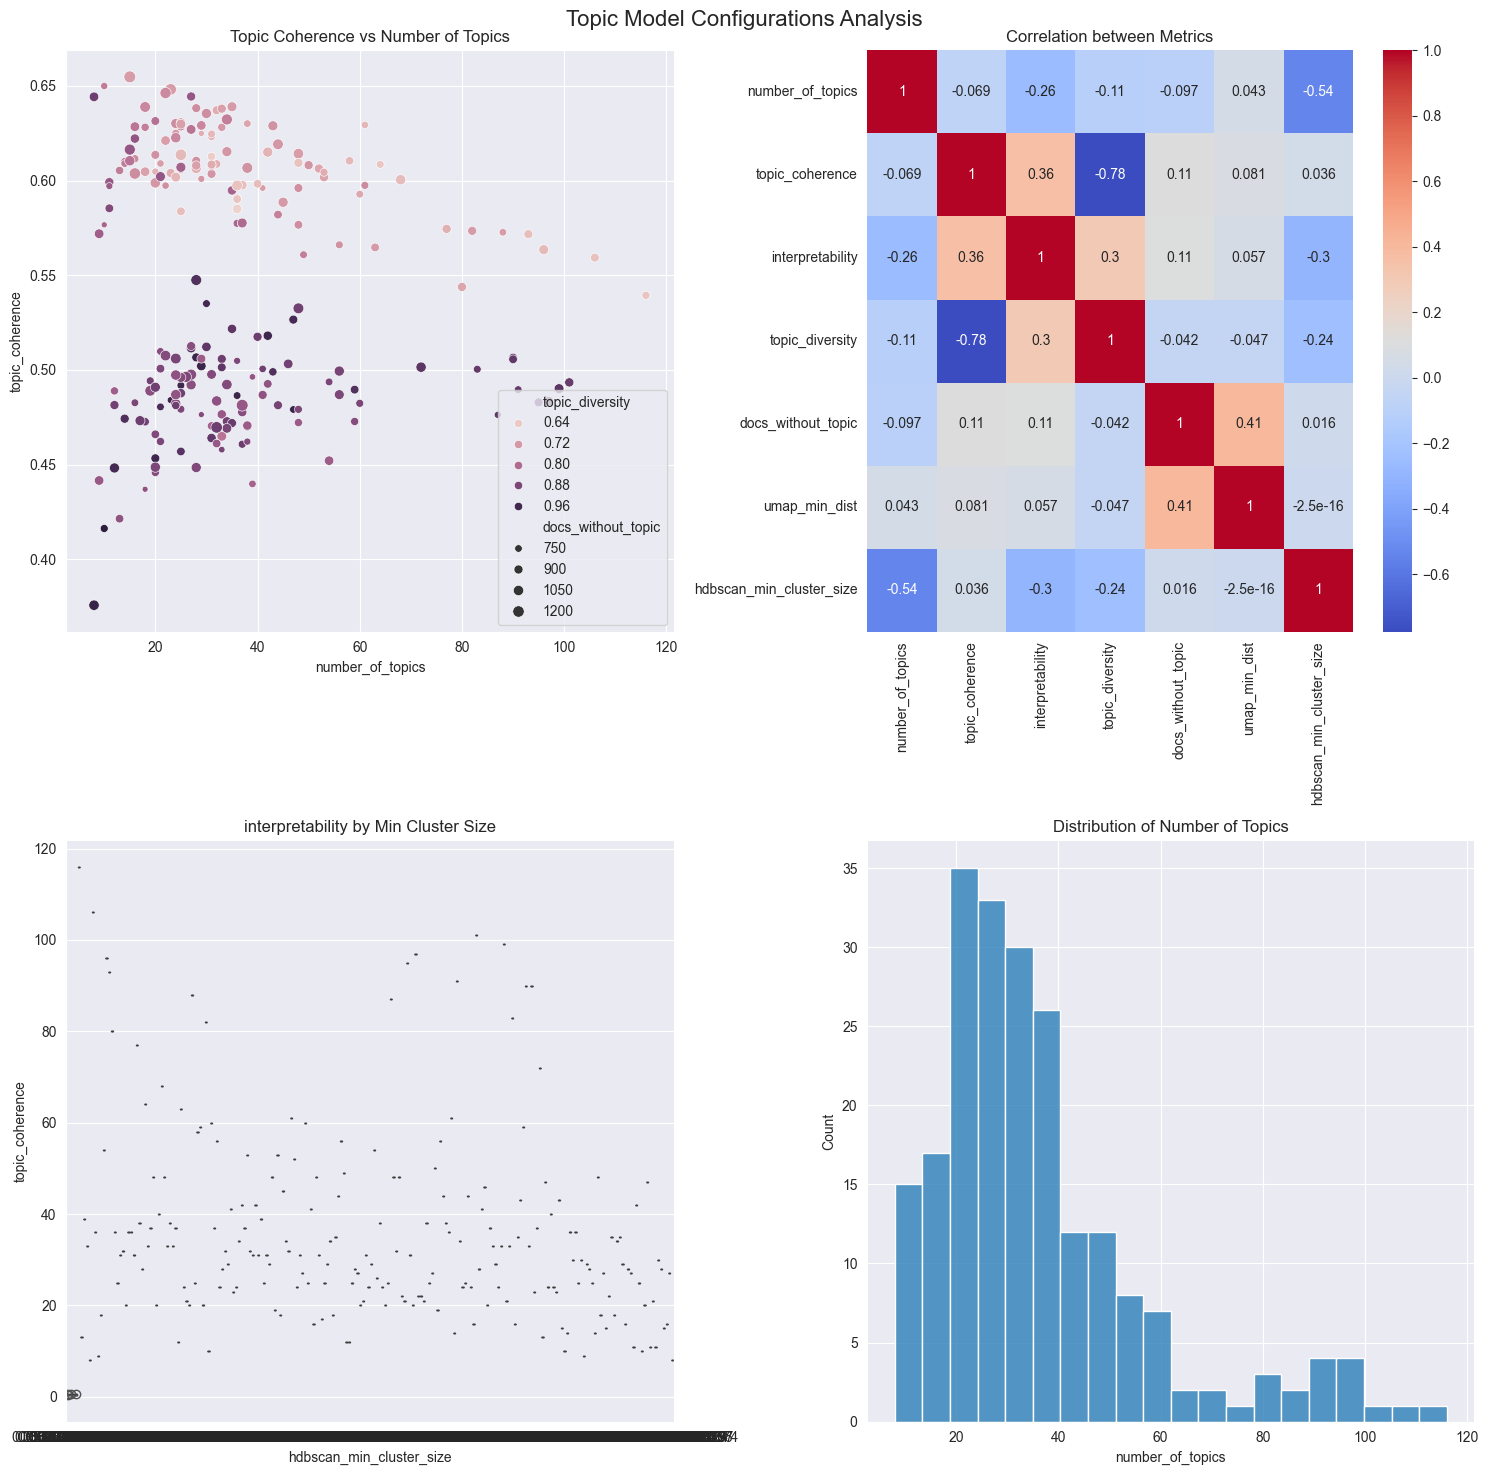

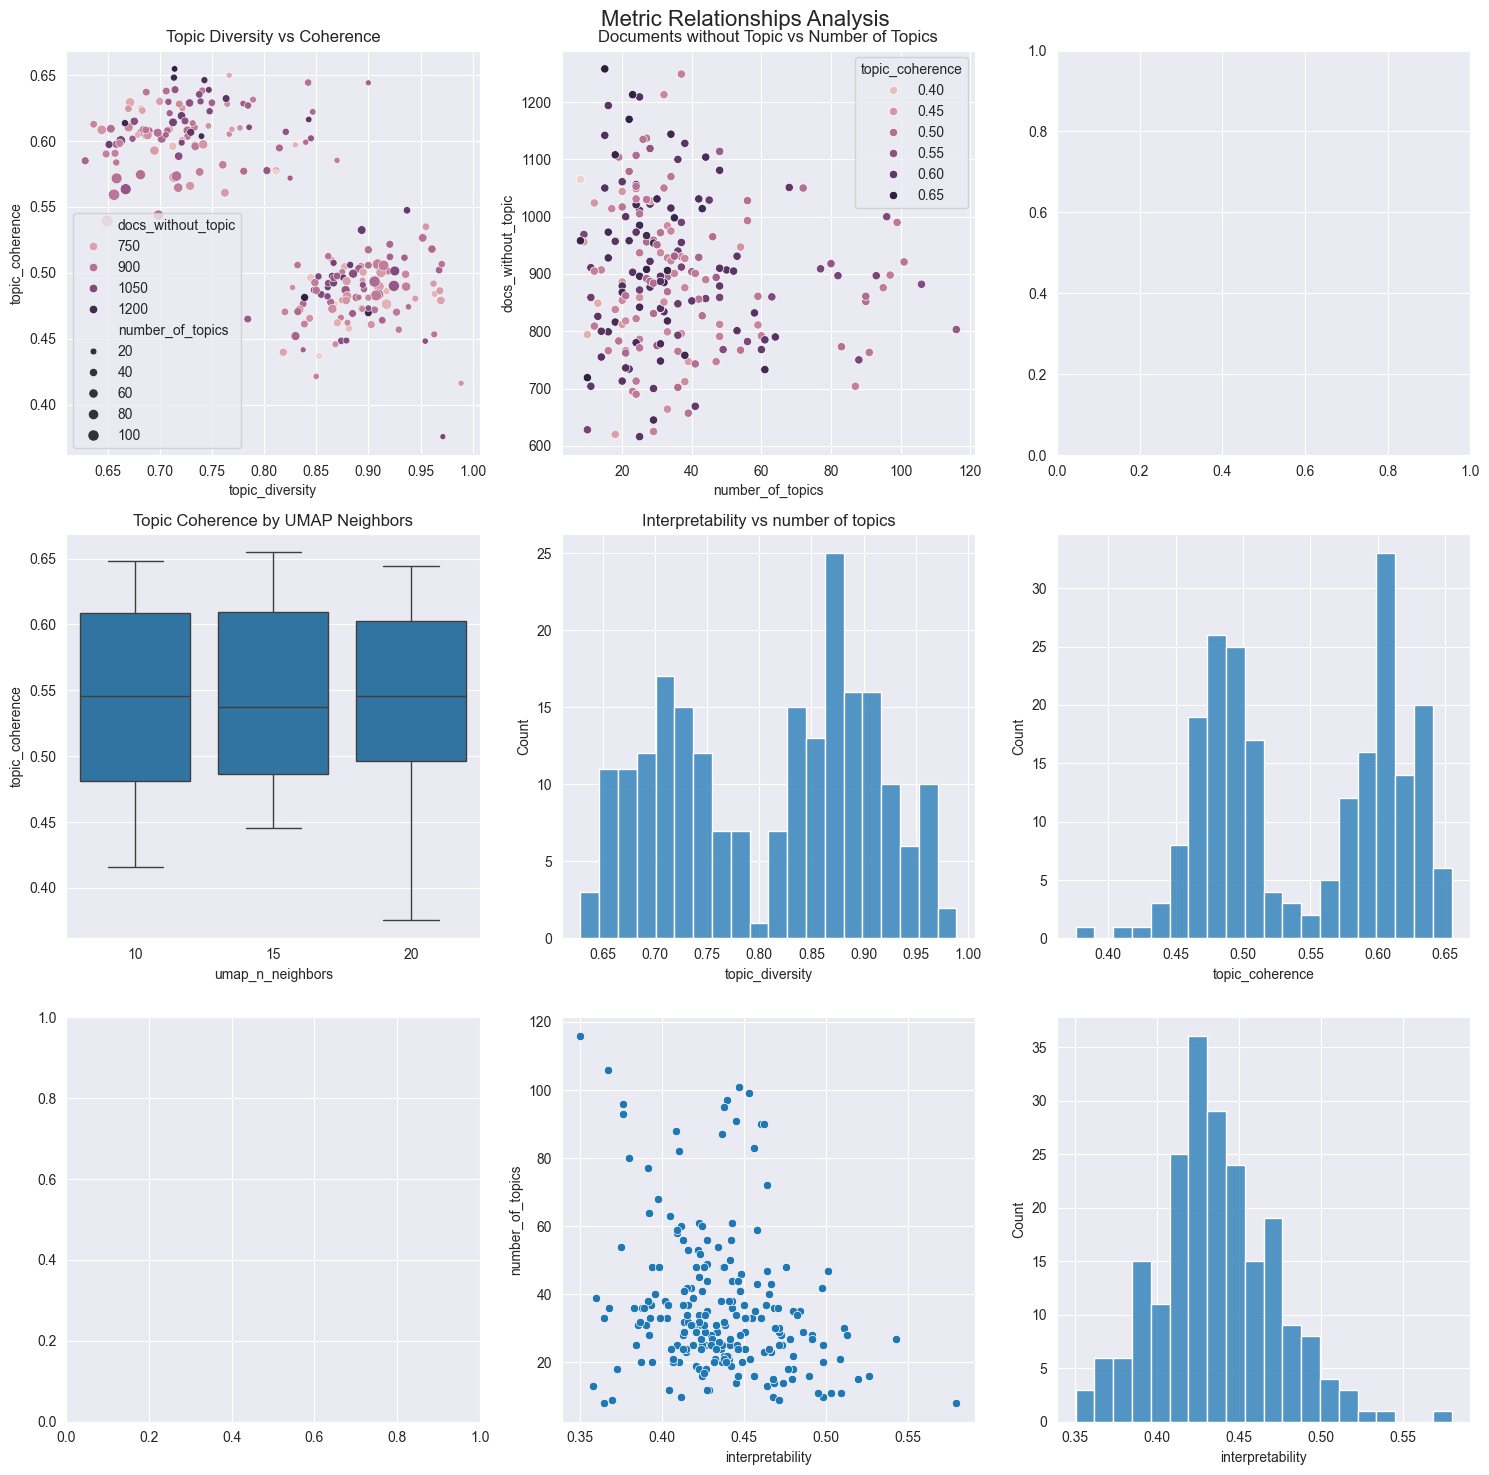

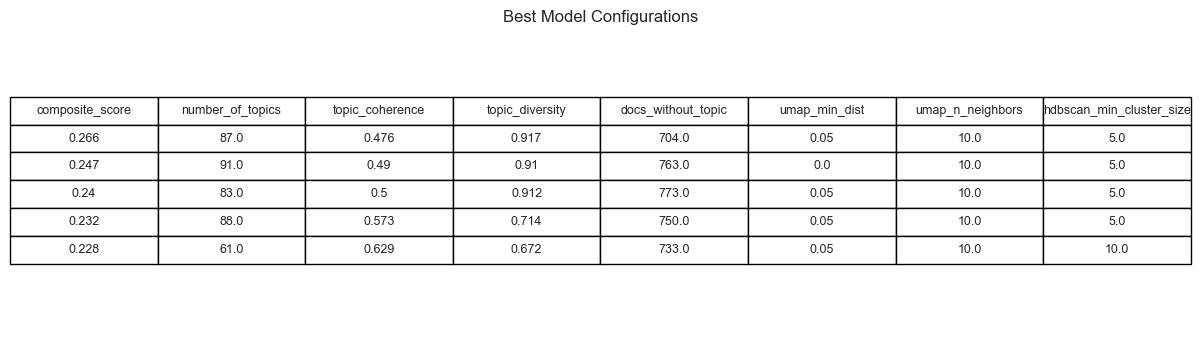

In [20]:
def find_best_models(results_df, n_best=5):
    """Find the best performing models based on multiple metrics."""
    # Create normalized scores for each metric
    metrics = ['topic_coherence', 'topic_diversity', 'number_of_topics']
    
    # Remove non-numeric columns and normalize
    scoring_df = results_df.copy()
    for metric in metrics:
        max_val = scoring_df[metric].max()
        min_val = scoring_df[metric].min()
        scoring_df[f'{metric}_normalized'] = (scoring_df[metric] - min_val) / (max_val - min_val)
    
    # Calculate composite score (you can adjust weights as needed)
    scoring_df['composite_score'] = (
        scoring_df['topic_coherence_normalized'] * 0.4 +
        scoring_df['topic_diversity_normalized'] * 0.3 +
        scoring_df['number_of_topics_normalized'] * 0.3
    )
    
    # Penalize for documents without topics
    scoring_df['composite_score'] = scoring_df['composite_score'] * (
        1 - scoring_df['docs_without_topic'] / scoring_df['docs_without_topic'].max()
    )
    
    # Get best models
    best_models = scoring_df.nlargest(n_best, 'composite_score')
    return best_models

def plot_results_2d(results_df):
    """Create 2D visualizations for the hyperparameter tuning results without WebGL dependency."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Remove the model and topics columns for plotting
    plot_df = results_df.drop(['model', 'topics', 'probs'], axis=1)
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Topic Model Configurations Analysis', fontsize=16)
    
    # 1. Scatter plot: Topic Coherence vs Number of Topics
    sns.scatterplot(
        data=plot_df,
        x='number_of_topics',
        y='topic_coherence',
        size='docs_without_topic',
        hue='topic_diversity',
        ax=axes[0,0]
    )
    axes[0,0].set_title('Topic Coherence vs Number of Topics')
    
    # 2. Heatmap of correlation between numeric parameters
    numeric_cols = ['number_of_topics', 'topic_coherence', 'interpretability', 'topic_diversity', 
                   'docs_without_topic', 'umap_min_dist', 'hdbscan_min_cluster_size']
    correlation = plot_df[numeric_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[0,1])
    axes[0,1].set_title('Correlation between Metrics')
    
    # 3. Box plots for key metrics across different HDBSCAN settings
    sns.boxplot(
        data=plot_df,
        x='hdbscan_min_cluster_size',
        y='topic_coherence',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Topic Coherence by Min Cluster Size')
    
    # 4. Box plots for key metrics across different HDBSCAN settings
    sns.boxplot(
        data=plot_df,
        x='hdbscan_min_cluster_size',
        y='interpretability',
        ax=axes[1,0]
    )
    axes[1,0].set_title('interpretability by Min Cluster Size')
    
    # 5. Box plots for key metrics across different HDBSCAN settings
    sns.boxplot(
        data=plot_df,
        x='interpretability',
        y='number_of_topics',
        ax=axes[1,0]
    )
    axes[1,0].set_title('interpretability by Min Cluster Size')
    
    
    
    # 6. Distribution of number of topics
    sns.histplot(
        data=plot_df,
        x='number_of_topics',
        bins=20,
        ax=axes[1,1]
    )
    axes[1,1].set_title('Distribution of Number of Topics')
    
    plt.tight_layout()
    return fig

def plot_metric_relationships(results_df):
    """Create additional 2D plots focusing on relationships between metrics."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Remove the model and topics columns for plotting
    plot_df = results_df.drop(['model', 'topics', 'probs'], axis=1)
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('Metric Relationships Analysis', fontsize=16)
    
    # 1. Topic Diversity vs Topic Coherence
    sns.scatterplot(
        data=plot_df,
        x='topic_diversity',
        y='topic_coherence',
        size='number_of_topics',
        hue='docs_without_topic',
        ax=axes[0,0]
    )
    axes[0,0].set_title('Topic Diversity vs Coherence')
    
    # 2. Documents without topic vs Number of topics
    sns.scatterplot(
        data=plot_df,
        x='number_of_topics',
        y='docs_without_topic',
        hue='topic_coherence',
        ax=axes[0,1]
    )
    axes[0,1].set_title('Documents without Topic vs Number of Topics')
    
    # 3. UMAP parameters effect
    sns.boxplot(
        data=plot_df,
        x='umap_n_neighbors',
        y='topic_coherence',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Topic Coherence by UMAP Neighbors')
    
    # 4. Topic diversity distribution
    sns.histplot(
        data=plot_df,
        x='topic_diversity',
        bins=20,
        ax=axes[1,1]
    )
    axes[1,1].set_title('Distribution of Topic Diversity')
    
    plt.tight_layout()
    
    # 5. Topic coherence distribution
    sns.histplot(
        data=plot_df,
        x='topic_coherence',
        bins=20,
        ax=axes[1,2]
    )
    axes[1,1].set_title('Distribution of Topic Coherence')
    
    plt.tight_layout()
    
    # 5. Topic coherence distribution
    sns.histplot(
        data=plot_df,
        x='interpretability',
        bins=20,
        ax=axes[2,2]
    )
    axes[1,1].set_title('Distribution of interpretability (diversity * coherence)')
    
    # 5. Topic coherence distribution
    sns.scatterplot(
        data=plot_df,
        x='interpretability',
        y='number_of_topics',
        ax=axes[2,1]
    )
    axes[1,1].set_title('Interpretability vs number of topics')
    
    plt.tight_layout()
    
    
    return fig

def create_summary_table(results_df, n_best=5):
    """Create a formatted summary table of the best configurations."""
    best_models = find_best_models(results_df, n_best)
    
    summary_df = best_models[[
        'composite_score',
        'number_of_topics',
        'topic_coherence',
        'topic_diversity',
        'docs_without_topic',
        'umap_min_dist',
        'umap_n_neighbors',
        'hdbscan_min_cluster_size'
    ]].round(3)
    
    # Create a more readable table format
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, n_best/2 + 1))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(
        cellText=summary_df.values,
        colLabels=summary_df.columns,
        cellLoc='center',
        loc='center'
    )
    
    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.title('Best Model Configurations')
    plt.tight_layout()
    
    return fig

# Example usage:
# results_df = run_hyperparameter_tuning(df_news, max_combinations=50)
# 
# # Create main visualization plots
fig1 = plot_results_2d(results_df)
fig2 = plot_metric_relationships(results_df)
# 
# # Create summary table
fig3 = create_summary_table(results_df)
# 
# # Show all plots
plt.show()

# Final model hyperparameters chosen

below is a table with each of the evaluated top performers of the BERTopic hyperparameter tuning process

In [42]:
results_df = pd.read_csv("results_hyperparameters.csv")
results_df = results_df.fillna(0)
results_df[results_df["iteration"].isin([5, 7, 100, 170, 173, 177, 200, 203])].round(decimals=3).drop(["embedding_model",  "umap_spread", "nr_topics_setting", "reduce_frequent_words", "model", "topics", "probs", "vectorizer_min_df"], axis=1)


,Unnamed: 0,iteration,umap_min_dist,umap_n_neighbors,hdbscan_min_cluster_size,hdbscan_min_samples,vectorizer_ngram_range,number_of_topics,docs_without_topic,topic_diversity,topic_coherence,interpretability
4,4,5,0.00,10,5,10.0,"(1, 1)",27,908,0.842,0.644,0.543
6,6,7,0.00,10,10,0.0,"(1, 1)",16,928,0.847,0.622,0.527
99,99,100,0.05,15,5,5.0,"(1, 2)",42,929,0.961,0.518,0.498
169,169,170,0.10,15,5,0.0,"(1, 2)",30,775,0.955,0.535,0.511
172,172,173,0.10,15,5,10.0,"(1, 1)",15,1142,0.843,0.616,0.519
176,176,177,0.10,15,10,5.0,"(1, 1)",21,1000,0.845,0.602,0.509
199,199,200,0.10,20,10,0.0,"(1, 2)",28,1119,0.937,0.547,0.513
202,202,203,0.10,20,10,10.0,"(1, 1)",8,958,0.900,0.644,0.580


### The best performing set of hyperparameters

In [55]:
results_df[results_df["iteration"] == 5]


,Unnamed: 0,iteration,embedding_model,umap_min_dist,umap_n_neighbors,umap_spread,hdbscan_min_cluster_size,hdbscan_min_samples,vectorizer_ngram_range,vectorizer_min_df,reduce_frequent_words,nr_topics_setting,number_of_topics,docs_without_topic,topic_diversity,topic_coherence,model,topics,probs,interpretability
4,4,5,SentenceTransformer,0.0,10,1.0,5,10.0,"(1, 1)",1,True,auto,27,908,0.842308,0.644381,"BERTopic(calculate_probabilities=False, ctfidf...","[0, -1, -1, -1, 0, 0, -1, 2, 2, 0, 0, -1, -1, ...",[0.4121435 0. 0. ... 1. 1...,0.542767


# Chatgpt representation

For the chatgpt representation, we pick the best performing set of hyperparameters to replace the representation model with the ChatGPT version of it. Then we will experiment with different prompts.

Let us first recreate the topics using the best found BERTopic hyperparameters. Then in later steps we replace the representation model with the one from OPENAI

In [65]:
custom_bert_parameters = {
    "language": "english",
    "nr_topics": 27,
    "document_embedding": SentenceTransformer("all-MiniLM-L6-v2"),
    "reduce_dimensionality": UMAP(min_dist=0.00, n_neighbors=10),
    "clustering": HDBSCAN(min_cluster_size=5, min_samples=10),
    "topic_tokenization": CountVectorizer(stop_words="english", ngram_range=(1, 1)),
    "topic_representation": ClassTfidfTransformer(reduce_frequent_words=True),
    "representation_model": KeyBERTInspired()#representation_model
}
topic_model_content, topics_numbers, probs_numbers = show_bertopic_evaluations(custom_bert_parameters, iteration=10000)
topic_model_content.visualize_barchart()

iteration =  10000
total number of topics =  27
documents without a topic =  733


In [66]:
topic_model_content.topic_representations_

{-1: [('stocks', 0.55848825),
  ('stock', 0.5095921),
  ('nyse', 0.50599945),
  ('nasdaq', 0.45200402),
  ('markets', 0.4259631),
  ('investors', 0.4223332),
  ('companies', 0.40848315),
  ('market', 0.4021063),
  ('industry', 0.39556152),
  ('dow', 0.3906002)],
 0: [('nasdaq', 0.4999689),
  ('stock', 0.47472134),
  ('nyse', 0.47209847),
  ('stocks', 0.46965358),
  ('companies', 0.4013927),
  ('investors', 0.38310027),
  ('market', 0.3793906),
  ('company', 0.37780172),
  ('shares', 0.37130255),
  ('earnings', 0.3280148)],
 1: [('stocks', 0.41373488),
  ('dow', 0.3943606),
  ('markets', 0.38781458),
  ('stock', 0.38608357),
  ('market', 0.34969574),
  ('trading', 0.34157696),
  ('nyse', 0.3380176),
  ('investors', 0.32370168),
  ('bullish', 0.32120413),
  ('futures', 0.3102976)],
 2: [('nvidia', 0.509223),
  ('gpu', 0.41634566),
  ('earnings', 0.40644157),
  ('nvda', 0.3924746),
  ('gpus', 0.3921877),
  ('nasdaq', 0.37169093),
  ('geforce', 0.35064977),
  ('revenues', 0.32172057),
  ('

In [68]:
import kaleido
import openai
from dotenv import load_dotenv
load_dotenv()
import os
from bertopic.representation import OpenAI

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
prompt= """
I have a topic that contains the following documents: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <topic label>
"""

representation_model = OpenAI(client=client, model="gpt-3.5-turbo", prompt=prompt, chat=True, delay_in_seconds=0.1)
topic_model_content.update_topics(representation_model=representation_model, docs=df_news["content"])
topic_model_content.topic_representations_

{-1: [('Semiconductor Industry Earnings Trends Analysis', 1)],
 0: [('Tech Stocks Analysis and Market Trends', 1)],
 1: [('Market News and Earnings Highlights', 1)],
 2: [("NVIDIA's Growth Prospects and Financial Performance", 1)],
 3: [('NVIDIA stock trading performance on NASDAQ exchange', 1)],
 4: [('Emerging Trends in Self-Driving Vehicle Technology', 1)],
 5: [('Economic Analysis and Market Trends Summary', 1)],
 6: [('U.S. stock market performance and trends analysis', 1)],
 7: [('Earnings Growth Trends and Estimates Analysis by Zacks', 1)],
 8: [('U.S.-China Trade Tensions, Huawei Blacklisting, Semiconductor Companies, Tariffs, Market Impact',
   1)],
 9: [("Facebook's initiatives for user safety and growth, developments in the social media landscape",
   1)],
 10: [("AMD's Radeon GPUs Revolutionizing the Gaming and Datacenter Markets",
   1)],
 11: [('Bitcoin and Ethereum in the Digital Currency Market', 1)],
 12: [('Technology Earnings Highlights and Emerging Trends in Gaming 

In [71]:
topic_model_content.visualize_topics()

In [72]:
# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
prompt = """
I have a topic that identifies a cluster of many news articles, the representative documents for this cluster are: 
[DOCUMENTS]
---
The topic is described by the following keywords: 
[KEYWORDS]
---
Based on the information above, extract a short topic label in the following format, be straight to the point, keep it between 1-5 words:
topic: <topic label>
"""

representation_model = OpenAI(client=client, model="gpt-3.5-turbo", prompt=prompt, chat=True, delay_in_seconds=0.1)
topic_model_content.update_topics(representation_model=representation_model, docs=df_news["content"])
topic_model_content.topic_representations_


{-1: [('Semiconductor Industry Trends', 1)],
 0: [('Stock Market Trends', 1)],
 1: [('Market Volatility and Earnings', 1)],
 2: [('Nvidia Q3 Earnings Outlook', 1)],
 3: [('NVIDIA stock trading fluctuations', 1)],
 4: [('Self-Driving Vehicle Technology', 1)],
 5: [('Market Analysis Recap', 1)],
 6: [('Stock Market Performance', 1)],
 7: [('Earnings Growth Trends', 1)],
 8: [('US-China trade tensions and impacts', 1)],
 9: [('Facebook Safety Initiatives', 1)],
 10: [('AMD Radeon GPU Performance', 1)],
 11: [('Bitcoin Surge and Impact', 1)],
 12: [('Video Game Industry Insights', 1)],
 13: [('AI Technology Stocks', 1)],
 14: [('Pure Storage Financial Performance', 1)],
 15: [('Cadence earnings outlook', 1)],
 16: [('Qualcomm antitrust fines', 1)],
 17: [("Tesla's Autonomous Driving Future", 1)],
 18: [('Senior Notes Offering Analysis', 1)],
 19: [('NetApp cloud revenues Flash', 1)],
 20: [("SoftBank's Vision Fund Expansion", 1)],
 21: [('Coronavirus Outbreak', 1)],
 22: [("Amazon's E-Comm

In [73]:
# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
prompt = """
I have a topic that identifies a cluster of many news articles, the representative documents for this cluster are: 
[DOCUMENTS]
---
The topic is described by the following keywords: 
[KEYWORDS]
---
Based on the information above, extract a short topic label that represents the theme of the topic. Be straight to the point, keep it between 1-5 words
Please respond in the format:
topic: <topic label>
"""

representation_model = OpenAI(client=client, model="gpt-3.5-turbo", prompt=prompt, chat=True, delay_in_seconds=0.1)
topic_model_content.update_topics(representation_model=representation_model, docs=df_news["content"])
topic_model_content.topic_representations_


{-1: [('Semiconductor Industry Trends', 1)],
 0: [('stock analysis and recommendations', 1)],
 1: [('Market Updates and Earnings', 1)],
 2: [('Nvidia Earnings and Growth', 1)],
 3: [('NVIDIA stock trading fluctuations', 1)],
 4: [('Autonomous Vehicle Technology', 1)],
 5: [('Market Analysis Insights', 1)],
 6: [('Stock Market Performance Analysis', 1)],
 7: [('Earnings Growth Trends', 1)],
 8: [('US-China trade tensions', 1)],
 9: [('Facebook security and growth strategies', 1)],
 10: [('AMD Graphics Market Dominance', 1)],
 11: [('Digital Currency Trends', 1)],
 12: [('Video Game Industry Highlights', 1)],
 13: [('Artificial Intelligence Stocks', 1)],
 14: [('Pure Storage financial performance', 1)],
 15: [('Cadence Earnings Analysis', 1)],
 16: [('Qualcomm antitrust fines', 1)],
 17: [("Tesla's Future Opportunities", 1)],
 18: [('Company Financial Offerings', 1)],
 19: [('NetApp financial performance', 1)],
 20: [("SoftBank's Vision Fund Expansion", 1)],
 21: [('Impact of Coronavirus

# The raw topic representation and the chatgpt created label

In [ ]:
raw_topics = {-1: [('stocks', 0.55848825),
  ('stock', 0.5095921),
  ('nyse', 0.50599945),
  ('nasdaq', 0.45200402),
  ('markets', 0.4259631),
  ('investors', 0.4223332),
  ('companies', 0.40848315),
  ('market', 0.4021063),
  ('industry', 0.39556152),
  ('dow', 0.3906002)],
 0: [('nasdaq', 0.4999689),
  ('stock', 0.47472134),
  ('nyse', 0.47209847),
  ('stocks', 0.46965358),
  ('companies', 0.4013927),
  ('investors', 0.38310027),
  ('market', 0.3793906),
  ('company', 0.37780172),
  ('shares', 0.37130255),
  ('earnings', 0.3280148)],
 1: [('stocks', 0.41373488),
  ('dow', 0.3943606),
  ('markets', 0.38781458),
  ('stock', 0.38608357),
  ('market', 0.34969574),
  ('trading', 0.34157696),
  ('nyse', 0.3380176),
  ('investors', 0.32370168),
  ('bullish', 0.32120413),
  ('futures', 0.3102976)],
 2: [('nvidia', 0.509223),
  ('gpu', 0.41634566),
  ('earnings', 0.40644157),
  ('nvda', 0.3924746),
  ('gpus', 0.3921877),
  ('nasdaq', 0.37169093),
  ('geforce', 0.35064977),
  ('revenues', 0.32172057),
  ('stock', 0.31685418),
  ('gaming', 0.3047709)],
 3: [('nvda', 0.46555558),
  ('nvidia', 0.45806924),
  ('nasdaq', 0.4539492),
  ('stock', 0.4476538),
  ('shares', 0.3652361),
  ('traded', 0.347098),
  ('investing', 0.32522497),
  ('exchange', 0.30819994),
  ('trade', 0.29973832),
  ('158', 0.28027666)],
 4: [('automakers', 0.53048813),
  ('automotive', 0.4929515),
  ('automaker', 0.45782125),
  ('uber', 0.43075866),
  ('bmw', 0.42248768),
  ('vehicles', 0.4215353),
  ('carmakers', 0.41373122),
  ('autonomous', 0.3964153),
  ('cars', 0.3934387),
  ('vehicle', 0.39253986)],
 5: [('week', 0.39267293),
  ('weekly', 0.36552474),
  ('trading', 0.33214998),
  ('investing', 0.31684637),
  ('traders', 0.29221874),
  ('market', 0.28146887),
  ('investment', 0.27446252),
  ('read', 0.27228707),
  ('trader', 0.26383296),
  ('impacts', 0.26213732)],
 6: [('nyse', 0.57721436),
  ('dow', 0.44218147),
  ('nasdaq', 0.43528372),
  ('shares', 0.41171667),
  ('index', 0.27606055),
  ('corporation', 0.26077008),
  ('sectors', 0.2381325),
  ('exchange', 0.22838888),
  ('commodities', 0.22674581),
  ('futures', 0.21926159)],
 7: [('earnings', 0.60835207),
  ('stocks', 0.44551516),
  ('revenues', 0.35835242),
  ('securities', 0.34116042),
  ('quarterly', 0.338189),
  ('finance', 0.32419032),
  ('revenue', 0.30623496),
  ('disclosure', 0.299124),
  ('investment', 0.28612673),
  ('estimates', 0.281638)],
 8: [('tariffs', 0.47345352),
  ('tariff', 0.4256894),
  ('huawei', 0.3536409),
  ('beijing', 0.33592469),
  ('china', 0.30428502),
  ('chinese', 0.30076107),
  ('commerce', 0.28304917),
  ('blacklisting', 0.263585),
  ('exports', 0.25802734),
  ('xinjiang', 0.24102557)],
 9: [('facebook', 0.55269957),
  ('advertisements', 0.47334597),
  ('ads', 0.45745578),
  ('advertisers', 0.43905807),
  ('fb', 0.4376014),
  ('advertising', 0.42201874),
  ('zuckerberg', 0.36312944),
  ('instagram', 0.3589608),
  ('ad', 0.33840078),
  ('messenger', 0.30702835)],
 10: [('amd', 0.59279865),
  ('radeon', 0.5669824),
  ('gpu', 0.5570969),
  ('gpus', 0.50818884),
  ('ryzen', 0.42880517),
  ('pcie', 0.3832687),
  ('processors', 0.3671316),
  ('intel', 0.35899323),
  ('gaming', 0.35729957),
  ('supercomputer', 0.34898046)],
 11: [('cryptocurrencies', 0.5448111),
  ('bitcoin', 0.5202105),
  ('cryptocurrency', 0.51842666),
  ('ethereum', 0.47726774),
  ('bitcoins', 0.4633595),
  ('crypto', 0.4214539),
  ('investors', 0.41482592),
  ('currencies', 0.4087555),
  ('btc', 0.40615773),
  ('traders', 0.39697444)],
 12: [('esports', 0.5260961),
  ('activision', 0.4285577),
  ('ea', 0.42458498),
  ('gaming', 0.42188874),
  ('crowdfunding', 0.40855008),
  ('entertainment', 0.38768774),
  ('franchises', 0.38694865),
  ('industry', 0.3844415),
  ('sports', 0.3758859),
  ('gamers', 0.36253947)],
 13: [('ai', 0.43695784),
  ('robots', 0.40577185),
  ('industry', 0.40295455),
  ('robotic', 0.39713854),
  ('industrial', 0.39435345),
  ('advancements', 0.38399392),
  ('robot', 0.38277197),
  ('technologies', 0.37568647),
  ('robotics', 0.37059158),
  ('cobots', 0.35982388)],
 14: [('storage', 0.4030338),
  ('gaap', 0.36545682),
  ('ssds', 0.36341906),
  ('revenues', 0.34606838),
  ('ssd', 0.34595582),
  ('enterprise', 0.3277868),
  ('seagate', 0.32067657),
  ('sandisk', 0.31886667),
  ('multimillion', 0.29881224),
  ('hdd', 0.29105297)],
 15: [('cadence', 0.35651937),
  ('outperforming', 0.33720466),
  ('revenues', 0.3163938),
  ('flagship', 0.29281867),
  ('gaap', 0.2636726),
  ('capabilities', 0.2571215),
  ('company', 0.25132188),
  ('suite', 0.20695576),
  ('management', 0.2033242),
  ('design', 0.19856286)],
 16: [('antitrust', 0.48444462),
  ('qualcomm', 0.48256516),
  ('lawsuits', 0.39256096),
  ('patents', 0.37003922),
  ('infringement', 0.3610466),
  ('lawsuit', 0.35314983),
  ('qcom', 0.3216607),
  ('chipmaker', 0.30889994),
  ('apple', 0.30800104),
  ('chipsets', 0.30529803)],
 17: [('tesla', 0.6208721),
  ('automakers', 0.38886204),
  ('carmaker', 0.3416903),
  ('car', 0.27581012),
  ('vehicle', 0.2703705),
  ('cars', 0.2680253),
  ('musk', 0.24717927),
  ('vehicles', 0.24489474),
  ('investors', 0.24346828),
  ('panasonic', 0.24310225)],
 18: [('securities', 0.45585057),
  ('dividend', 0.38612628),
  ('txn', 0.36184102),
  ('dividends', 0.34869802),
  ('debt', 0.3421846),
  ('repurchases', 0.34085634),
  ('cash', 0.33983415),
  ('acquisitions', 0.3304639),
  ('repurchase', 0.32735646),
  ('notes', 0.31057507)],
 19: [('netapp', 0.49664277),
  ('revenues', 0.3807511),
  ('ntap', 0.3458646),
  ('enterprises', 0.33069193),
  ('net', 0.3074882),
  ('gaap', 0.2999036),
  ('azure', 0.25207105),
  ('strategic', 0.24669918),
  ('capabilities', 0.24579477),
  ('company', 0.2415807)],
 20: [('softbank', 0.46160808),
  ('fund', 0.4139318),
  ('investors', 0.38919657),
  ('investments', 0.38724172),
  ('investment', 0.37389827),
  ('firms', 0.34480596),
  ('conglomerate', 0.34000552),
  ('ventures', 0.33912563),
  ('firm', 0.32321995),
  ('corp', 0.29626578)],
 21: [('coronavirus', 0.63062525),
  ('coronaviruses', 0.6296896),
  ('outbreak', 0.45581317),
  ('pandemic', 0.45285583),
  ('epidemics', 0.44311628),
  ('pandemics', 0.43358427),
  ('epidemic', 0.4226092),
  ('influenza', 0.41354465),
  ('viruses', 0.36688846),
  ('virus', 0.35402253)],
 22: [('ecommerce', 0.5019246),
  ('amazon', 0.4641474),
  ('retailer', 0.4602273),
  ('retailers', 0.44920552),
  ('aws', 0.42855468),
  ('sales', 0.3896802),
  ('retail', 0.38200414),
  ('commerce', 0.37958252),
  ('mart', 0.347213),
  ('logistics', 0.32774362)],
 23: [('infringement', 0.42361826),
  ('lawsuit', 0.35620776),
  ('google', 0.35398224),
  ('copyright', 0.33110386),
  ('revenue', 0.32026368),
  ('companies', 0.3194831),
  ('amazon', 0.29421532),
  ('microsoft', 0.2935543),
  ('ads', 0.28606212),
  ('youtube', 0.28587258)],
 24: [('dividends', 0.5871569),
  ('dividend', 0.53400564),
  ('stocks', 0.53280216),
  ('investment', 0.38128406),
  ('securities', 0.37101877),
  ('shareholders', 0.34788272),
  ('shareholder', 0.32781377),
  ('portfolio', 0.3139305),
  ('financial', 0.30107284),
  ('strategies', 0.2731012)],
 25: [('marvell', 0.40927303),
  ('ssd', 0.35781324),
  ('ethernet', 0.30629975),
  ('networking', 0.29598257),
  ('sse', 0.29335493),
  ('drives', 0.29112983),
  ('enterprise', 0.28614363),
  ('acquire', 0.2835034),
  ('vpx', 0.28117794),
  ('5g', 0.27675766)]}

chatgpt_represenation_1 = {-1: [('Semiconductor Industry Earnings Trends Analysis', 1)],
 0: [('Tech Stocks Analysis and Market Trends', 1)],
 1: [('Market News and Earnings Highlights', 1)],
 2: [("NVIDIA's Growth Prospects and Financial Performance", 1)],
 3: [('NVIDIA stock trading performance on NASDAQ exchange', 1)],
 4: [('Emerging Trends in Self-Driving Vehicle Technology', 1)],
 5: [('Economic Analysis and Market Trends Summary', 1)],
 6: [('U.S. stock market performance and trends analysis', 1)],
 7: [('Earnings Growth Trends and Estimates Analysis by Zacks', 1)],
 8: [('U.S.-China Trade Tensions, Huawei Blacklisting, Semiconductor Companies, Tariffs, Market Impact',
   1)],
 9: [("Facebook's initiatives for user safety and growth, developments in the social media landscape",
   1)],
 10: [("AMD's Radeon GPUs Revolutionizing the Gaming and Datacenter Markets",
   1)],
 11: [('Bitcoin and Ethereum in the Digital Currency Market', 1)],
 12: [('Technology Earnings Highlights and Emerging Trends in Gaming Industry',
   1)],
 13: [('The Growing Influence of Artificial Intelligence in Robotics and Technology',
   1)],
 14: [('Pure Storage Inc - Recent Earnings and Growth Outlook', 1)],
 15: [('Cadence Design Systems Quarterly Financial Performance and Outlook',
   1)],
 16: [('Qualcomm fined by European Commission for antitrust practices and abuse of market power',
   1)],
 17: [("Tesla's Innovation and Future Prospects", 1)],
 18: [('Financial Offerings and Cash Positions of Pure Storage Inc and Texas Instruments Incorporated',
   1)],
 19: [('NetApp Inc fiscal quarter performance and cloud solutions', 1)],
 20: [("SoftBank's Vision Fund and Investment Strategies", 1)],
 21: [('Impact of Coronavirus Outbreak on Global Companies and Economy', 1)],
 22: [("Amazon's Expansion and Technology Influence", 1)],
 23: [("Google vs Oracle fair use case and Alphabet's efforts to combat piracy, Microsoft Worldwide Partner Conference highlights, Facebook's potential partnership with ESPN and others, Intel's strategic board addition, Seagate's preliminary results and job cuts.",
   1)],
 24: [('Dividend Growth Stocks for Secure Retirement', 1)],
 25: [("Marvell Technology Group's Strong Performance in SSD and Ethernet Markets",
       )]}
chatgpt_represenation_2 = {-1: [('Semiconductor Industry Trends', 1)],
 0: [('Stock Market Trends', 1)],
 1: [('Market Volatility and Earnings', 1)],
 2: [('Nvidia Q3 Earnings Outlook', 1)],
 3: [('NVIDIA stock trading fluctuations', 1)],
 4: [('Self-Driving Vehicle Technology', 1)],
 5: [('Market Analysis Recap', 1)],
 6: [('Stock Market Performance', 1)],
 7: [('Earnings Growth Trends', 1)],
 8: [('US-China trade tensions and impacts', 1)],
 9: [('Facebook Safety Initiatives', 1)],
 10: [('AMD Radeon GPU Performance', 1)],
 11: [('Bitcoin Surge and Impact', 1)],
 12: [('Video Game Industry Insights', 1)],
 13: [('AI Technology Stocks', 1)],
 14: [('Pure Storage Financial Performance', 1)],
 15: [('Cadence earnings outlook', 1)],
 16: [('Qualcomm antitrust fines', 1)],
 17: [("Tesla's Autonomous Driving Future", 1)],
 18: [('Senior Notes Offering Analysis', 1)],
 19: [('NetApp cloud revenues Flash', 1)],
 20: [("SoftBank's Vision Fund Expansion", 1)],
 21: [('Coronavirus Outbreak', 1)],
 22: [("Amazon's E-Commerce Expansion", 1)],
 23: [('Tech Industry News', 1)],
 24: [('Dividend Growth Stocks', 1)],
 25: [("Marvell's Strong Performance", 1)]}
chatgpt_represenation_3 = {-1: [('Semiconductor Industry Trends', 1)],
 0: [('stock analysis and recommendations', 1)],
 1: [('Market Updates and Earnings', 1)],
 2: [('Nvidia Earnings and Growth', 1)],
 3: [('NVIDIA stock trading fluctuations', 1)],
 4: [('Autonomous Vehicle Technology', 1)],
 5: [('Market Analysis Insights', 1)],
 6: [('Stock Market Performance Analysis', 1)],
 7: [('Earnings Growth Trends', 1)],
 8: [('US-China trade tensions', 1)],
 9: [('Facebook security and growth strategies', 1)],
 10: [('AMD Graphics Market Dominance', 1)],
 11: [('Digital Currency Trends', 1)],
 12: [('Video Game Industry Highlights', 1)],
 13: [('Artificial Intelligence Stocks', 1)],
 14: [('Pure Storage financial performance', 1)],
 15: [('Cadence Earnings Analysis', 1)],
 16: [('Qualcomm antitrust fines', 1)],
 17: [("Tesla's Future Opportunities", 1)],
 18: [('Company Financial Offerings', 1)],
 19: [('NetApp financial performance', 1)],
 20: [("SoftBank's Vision Fund Expansion", 1)],
 21: [('Impact of Coronavirus on Global Economy', 1)],
 22: [("Amazon's E-commerce Expansion", 1)],
 23: [('Technology Partnerships', 1)],
 24: [('dividend growth stocks', 1)],
 25: [('Marvell Technology Growth', 1)]}

data = {
    "type": ["raw_topics", "chatgpt_representation_1", "chatgpt_representation_2", "chatgpt_representation_3"],
    "prompt": ["N/A", "Custom Prompt 1", "Custom Prompt 2", "Custom Prompt 3"],
    "topic_representation": [
        # Extracting just the list of words from the raw topics
        [[word for word, _ in topic] for topic in raw_topics.values()],
        [entry[0] for topic in chatgpt_represenation_1.values() for entry in topic],
        [entry[0] for topic in chatgpt_represenation_2.values() for entry in topic],
        [entry[0] for topic in chatgpt_represenation_3.values() for entry in topic],
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)
#df.to_csv("topic_representation_chatgpt_bertopic.csv")

# Topics over time

In [74]:
topics_over_time = topic_model_content.topics_over_time(df_news["content"], df_news["release_date"])
#topic_model_content.visualize_topics_over_time(topics_over_time).write_image("topics_over_time_final.jpg")

2024-11-07 00:03:45,439 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1003) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 20919 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}